## Class functions for matching and plotting. 

Catalogs to match
* Pilot study of the 100d with vl05_lgt5
* Then 100d with the cosmology sample. 
* Then full SPT catalog with the cosmology sample. 

Primary features to add: 
* ~~Matching by aperture if redshift information is not avialable.~~
* ~~Plotting the scaling relation of top matched clusters~~
* ~~Function to find SPT clusters with multiple RM matches~~
* ~~Redshift cut.~~
* ~~Plotting the matching properties (delta_z, D_sep, richness) of matched candidates.~~ 
* ~~Table showing how matching changes with Delta_z and D_sep~~
* Function/Plot to examine individual clusters. 
* Wrapper to change the name of all files to uniform name, e.g. ra, Dec to all capitalized RA, DEC. 

Secondary features and bug fixes to add:
* ~~SPT name and field strings are in bytes convert to string to remove the 'b precursor.~~ Done by using the convert_bytestring_to_unicode() function for a CSV file.
* ~~Divide by zero warning when converting into coordinates. This does not happen in my other file.~~
* ~~VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray~~
* Added the optional verbose parameter

Bugs to fix:
* ~~Change 'xi' parameter to capitalized 'XI' or 'PEAKSIG' to be consisten with other parameter input for the SPT catalog.~~ 


In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from glob import glob
import numpy as np
import healpy as hp
import struct

import setup
from astropy.table import Table
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy.io import fits

import pandas as pd
from tqdm import tqdm
import math

import pickle
from matched_clusters import matched_clusters

In [2]:
#Plotting params
#Plotting parameters
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter


mpl.rcParams['xtick.direction'], mpl.rcParams['ytick.direction'] = 'in', 'in'
mpl.rcParams['xtick.major.size'], mpl.rcParams['xtick.minor.size'] = 14, 8
mpl.rcParams['xtick.major.width'], mpl.rcParams['xtick.minor.width'] = 1.2, 0.8
mpl.rcParams['xtick.major.pad'], mpl.rcParams['xtick.minor.pad'] = 10, 10
mpl.rcParams['ytick.major.size'], mpl.rcParams['ytick.minor.size'] = 14, 8
mpl.rcParams['ytick.major.width'], mpl.rcParams['ytick.minor.width'] = 1.2, 0.8
mpl.rcParams['xtick.labelsize'], mpl.rcParams['ytick.labelsize'] = 20, 20

# Parameters used in this module
# One dictionary to store default values
# Another that user can view/change as necessary
Default_Params = {'default_cmap'   : plt.cm.coolwarm,
                  'title_fontsize' : 25,
                  'legend_fontsize': 22,
                  'xlabel_fontsize': 30,
                  'ylabel_fontsize': 30,
                  'scatter_factor' : 1.0}

Params = Default_Params.copy()

## Importing Catalogs

In [3]:
##Created a combined dataframe of SPT matched DES clusters in the DES Y3 footprint. 
datadir = setup.data_home_dir()
bigdatadir = setup.bigdata_home_dir()

### For SPT:
* MCMF SZ
* ECS 
* 100dpol
* Near future to add 500dpol catalog

In [5]:

#SPT
spt_all = datadir + 'spt_catalogs/sptpol100d_catalog_huang19.fits'
#spt_all = datadir + 'spt_catalogs/SPT_ECS_MCMFSZ_100d_Combined.fits'

#DES--redMaPPer full run vl50

dat = Table.read(spt_all, format='fits')
dat.convert_bytestring_to_unicode() #Converts bytes to string for string columns e.g. SPT ID and Field name for correct syntax

spt_data = dat.to_pandas()

print(spt_data.columns)
print("Number of clusters equals", len(spt_data))

Index(['SPT_ID', 'RA', 'Dec', 'xi', 'theta_core', 'redshift', 'redshift_unc',
       'M500', 'M500_lerr', 'M500_uerr', 'imaging', 'P_blank', 'field'],
      dtype='object')
Number of clusters equals 89


### redMaPPer
lgt5_vl50

In [36]:
redM_full = datadir + '/redMaPPer/y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt5_vl50_catalog.csv'
redM_full = pd.read_csv(redM_full)
print(redM_full.columns)
print("Number of clusters equals", len(redM_full))

Index(['MEM_MATCH_ID', 'RA', 'DEC', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG',
       'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z',
       'Z_SPEC_INIT', 'Z_INIT', 'Z', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E',
       'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC',
       'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ',
       'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE',
       'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG',
       'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ',
       'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT',
       'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT',
       'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT',
       'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW',
       'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD',
       'MASKGAL_INDEX'],
      dtype='object')

In [7]:
redM_cosmo = datadir + '/redMaPPer/y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl02_catalog.csv'
redM_cosmo = pd.read_csv(redM_cosmo)
print(redM_cosmo.columns)
print("Number of clusters equals", len(redM_cosmo))

Index(['MEM_MATCH_ID', 'RA', 'DEC', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG',
       'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z',
       'Z_SPEC_INIT', 'Z_INIT', 'Z', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E',
       'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC',
       'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ',
       'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE',
       'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG',
       'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ',
       'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT',
       'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT',
       'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT',
       'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW',
       'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD',
       'MASKGAL_INDEX'],
      dtype='object')

### Renamining Column Names if needed

In [38]:
##Renaming some of the SPT and RedmaPPer column names to avoid using the same name. 
spt_data.rename(columns = {"RA":"RA_SPT", "Dec":"DEC_SPT", "xi":"XI", "redshift":"Z_SPT", "field":"FIELD"}, inplace=True)
print(spt_data.columns)

#Remove space in FIELD names
spt_data['FIELD'] = spt_data['FIELD'].map(lambda string: string.replace(" ", ""))
print(spt_data['FIELD'].unique())

## For RedMaPPer
redM_full.rename(columns = {"RA":"RA_REDM", "DEC":"DEC_REDM", "Z":"Z_REDM"}, inplace=True)
redM_cosmo.rename(columns = {"RA":"RA_REDM", "DEC":"DEC_REDM", "Z":"Z_REDM"}, inplace=True)

Index(['SPT_ID', 'RA_SPT', 'DEC_SPT', 'XI', 'theta_core', 'Z_SPT',
       'redshift_unc', 'M500', 'M500_lerr', 'M500_uerr', 'imaging', 'P_blank',
       'FIELD', 'HPIX'],
      dtype='object')
['SPTPOL_100d']


In [15]:
#Filter

#mask = (spt_data.XI > 4.5)
#mask &= (spt_data.Z_SPT > 0.25) & (spt_data.Z_SPT < 0.65)

#spt_data = spt_data[mask]
print("After cut number of clusters: ", len(spt_data), "\n")

After cut number of clusters:  89 



## Apply Cluster Masking

Apply the fullrun mask for looser matching criterion. 

In [16]:
RM_zmax_file = bigdatadir + 'redMaPPer/' + 'y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl50_vlim_zmask.csv'

In [17]:
RM_zmax = pd.read_csv(RM_zmax_file)

#### Cleaning data in the zmask file

In [18]:
#Converting HPIX into integer
RM_zmax['HPIX'] = RM_zmax['HPIX'].astype(int)

In [19]:
#Drop duplicated
print("Length of file is", len(RM_zmax)) 
RM_zmax.drop_duplicates(subset=['HPIX'], inplace=True)
print("After dropping duplicated length of file is", len(RM_zmax)) 

Length of file is 31469613
After dropping duplicated length of file is 22841162


In [20]:
# Remove NAN values
print("Length of file is", len(RM_zmax)) 
RM_zmax.dropna(inplace=True)
print("After removing NAN length of file is", len(RM_zmax)) 

Length of file is 22841162
After removing NAN length of file is 22841161


In [21]:
#Replace NAN values with 0
print(RM_zmax['FRACGOOD'].isnull().sum())
RM_zmax['FRACGOOD'] = RM_zmax['FRACGOOD'].fillna(0)

0


#### Apply zmask matching

In [22]:
spt_pix=hp.ang2pix(4096, spt_data.RA_SPT.values, spt_data.DEC_SPT.values, lonlat=True)

In [23]:
spt_data['HPIX'] = spt_pix

In [24]:
spt_data = spt_data[spt_data.HPIX.isin(RM_zmax.HPIX)]
print("Number of SPT clusters in the DES Y3 cosmology footprint is", len(spt_data))

Number of SPT clusters in the DES Y3 cosmology footprint is 84


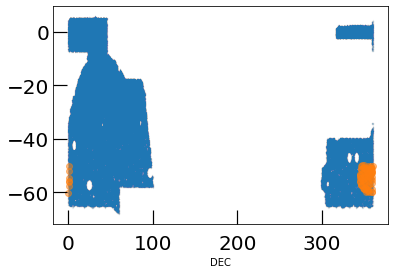

In [25]:
##Plotting the SPT coordinates after matching
plt.scatter(redM_full.RA_REDM, redM_full.DEC_REDM, alpha=0.05, s=0.1)
plt.scatter(spt_data.RA_SPT, spt_data.DEC_SPT, alpha=0.5)
plt.xlabel('RA'); plt.xlabel('DEC')
plt.show()

## Matching

In [27]:
a = matched_clusters(spt_data, redMfull, [0,2], verbose=False)
a.run_match(['RA_SPT','DEC_SPT','XI', 'Z_SPT'], ['RA_REDM','DEC_REDM','LAMBDA_CHISQ', 'Z_REDM'], \
                       1500, delta_z_lim = 0.1, aperture_type = 'distance', verbose=True)

Before z_cut number of SPT clusters is  84
Before z cut number of RM clusters is  21092
After z cut number of SPT clusters is  74
After z cut number of RM clusters is  21092


100%|██████████| 74/74 [00:00<00:00, 80.71it/s]


### (Optional) Pickle the class objecet

### Analysis of the Matched Catalog

In [28]:
match_candidates_df = a.get_match_candidates_df()
match_top_df = a.get_match_top_df()
nomatch_df = a.get_nomatch_df()
num_match = a.get_num_match()
num_multiple = a.get_multiple_candidates()['num_multiple']
print("Number of matches", num_match)
print("Number of multiple candidate matches",num_multiple)

Number of matches 41
Number of multiple candidate matches 0


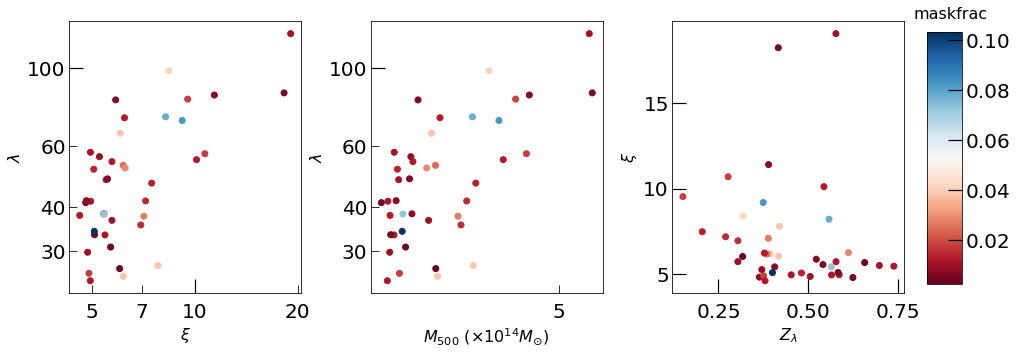

In [29]:
a.plot_scaling_relations()

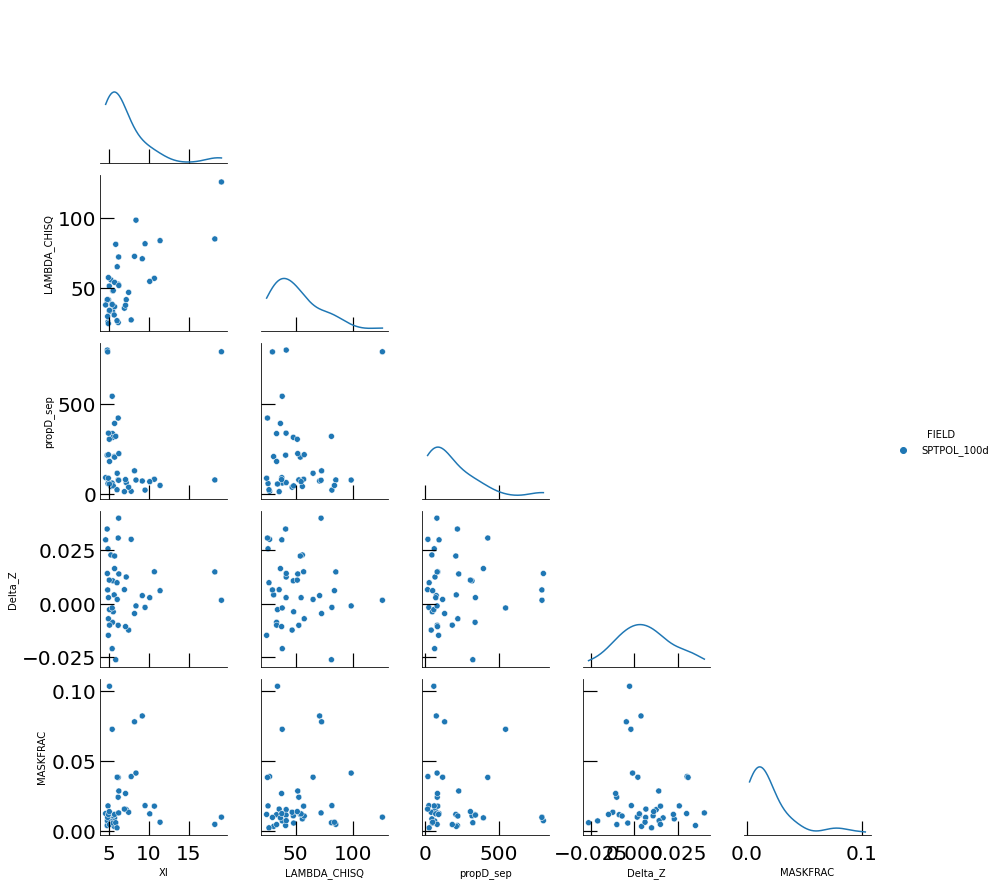

In [30]:
a.plot_matched_properties()

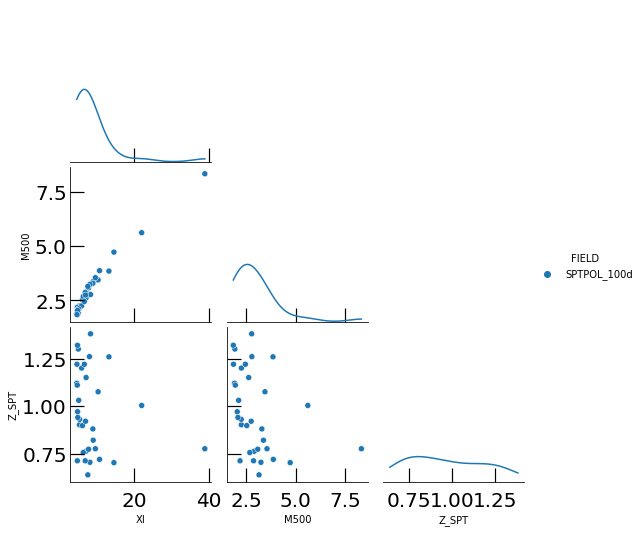

In [31]:
a.plot_nomatch_properties()

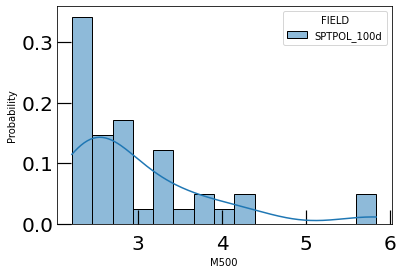

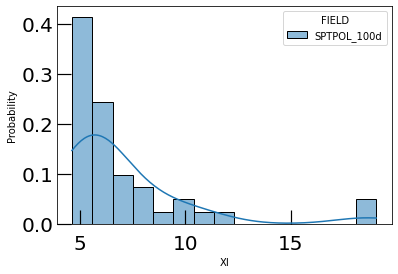

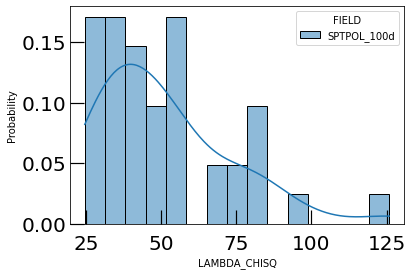

In [32]:
sns.histplot(data=match_top_df, x='M500', hue='FIELD', stat='probability', kde=True, common_norm=False, bins=15)
plt.show()
sns.histplot(data=match_top_df, x='XI', hue='FIELD', stat='probability', kde=True, common_norm=False, bins=15)
plt.show()
sns.histplot(data=match_top_df, x='LAMBDA_CHISQ', hue='FIELD', stat='probability', kde=True, common_norm=False, bins=15)
plt.show()

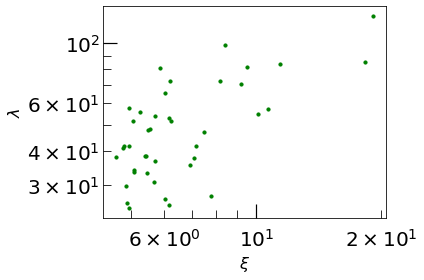

In [59]:
## More plotting for the matched clusters. 
fontsize = 16
plt.figure(tight_layout=True)
plt.scatter(match_top_df['XI'], match_top_df['LAMBDA_CHISQ'], color='green', s=10)
plt.xlabel(r'$\xi$', fontsize=16); plt.ylabel(r'$\lambda$', fontsize=16)
plt.yscale('log'); plt.xscale('log'); 
plt.savefig('sptpol100d_rmfull_lambda_vs_xi.png')
plt.show()

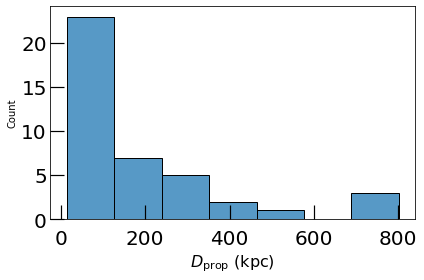

In [66]:
## More plotting for the matched clusters. 
fontsize = 16
plt.figure(tight_layout=True)
sns.histplot(match_top_df['propD_sep'])
plt.xlabel(r'$D_{\rm prop}$ (kpc)', fontsize=16)

#plt.savefig('sptpol100d_rmfull_propD_sep.png')
plt.show()

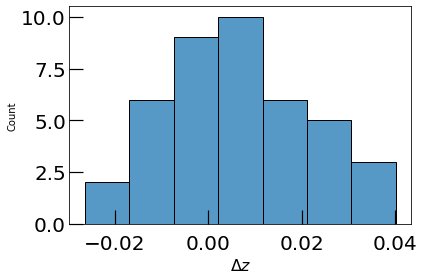

In [68]:
## More plotting for the matched clusters. 
fontsize = 16
plt.figure(tight_layout=True)
sns.histplot(match_top_df['Delta_Z'])
plt.xlabel(r'$\Delta z$', fontsize=16)

#plt.savefig('sptpol100d_rmfull_Delta_z.png')
plt.show()

### Changes the aperture size and redshift range to find how matching properties changes as a result. 


In [46]:
'''
Creates a dataframe of matching properties with aperture and redshift separation iterated. 

Parameters:
matched_cl: a matched_clusters object
delta_d_lim: A 1D list of distance separation
delta_z_lim: A 1D list of redshift separation. 

Returns:
iterate_match_df: A dataframe containing columns ['d_lim', 'delta_z_lim', 'num_match', 'num_multiple']
'''

def run_match_iterate(matched_cl, delta_d_lim, delta_z_lim):
    
    iterate_match_df = pd.DataFrame(columns=['d_lim', 'delta_z_lim', 'num_match', 'num_multiple'])

    for i, d_cur in tqdm(enumerate(delta_d_lim)):
        for j, z_lim_cur in enumerate(delta_z_lim):

            matched_cl.run_match(['RA_SPT','DEC_SPT','XI', 'Z_SPT'], ['RA_REDM','DEC_REDM','LAMBDA_CHISQ', 'Z_REDM'], \
                    d_cur, delta_z_lim = z_lim_cur, aperture_type = 'distance', verbose=False)

            iterate_match_df = iterate_match_df.append({'d_lim': d_cur, 'delta_z_lim': z_lim_cur, \
                                     'num_match':matched_cl.get_num_match(), \
                                     'num_multiple':matched_cl.get_multiple_candidates()['num_multiple']}, ignore_index=True)
    return iterate_match_df
        
'''
Plots heatmap of number of matches and multiple matches as a function of redshift limit and distance separation limit. 
'''
#Use groupby to sort and 
def plot_match_iterate(iterate_match_df, savefig=False, figname='something'):
    plt.figure(tight_layout=True)
    sns.heatmap(iterate_match_df.pivot_table(index = 'd_lim',columns ='delta_z_lim',values ='num_match'), annot=True)
    if savefig:
        plt.savefig('num_match_' + figname + '.png')
    
    plt.show()
    
    plt.figure(tight_layout=True)
    sns.heatmap(iterate_match_df.pivot_table(index = 'd_lim',columns ='delta_z_lim',values ='num_multiple'), annot=True)
    if savefig:
        plt.savefig('num_multiple_' + figname + '.png')
    plt.show()
    return

In [39]:
delta_d_lim = [800, 1000,1200,1500, 2000]
delta_z_lim = [0.08,0.1,0.12,0.15,0.2]
matched_cl = matched_clusters(spt_data, redM_full, verbose=True)

Number of clusters in SPT is: 84
Number of clusters in DES is: 869335
SPT columns: 
 ['SPT_ID', 'RA_SPT', 'DEC_SPT', 'XI', 'theta_core', 'Z_SPT', 'redshift_unc', 'M500', 'M500_lerr', 'M500_uerr', 'imaging', 'P_blank', 'FIELD', 'HPIX']
DES columns: 
 ['MEM_MATCH_ID', 'RA_REDM', 'DEC_REDM', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z_REDM', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC', 'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ', 'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE', 'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG', 'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT', 'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT', 'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT', 

In [40]:
iterate_match_df = run_match_iterate(matched_cl, delta_d_lim, delta_z_lim)

5it [04:36, 55.27s/it]


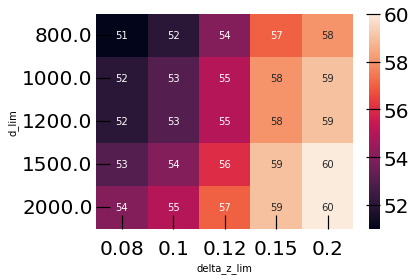

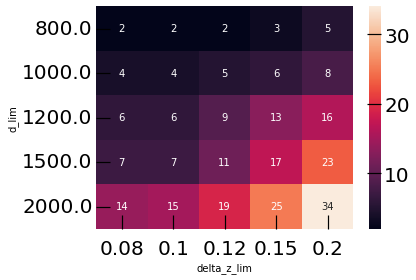

In [47]:
plot_match_iterate(iterate_match_df, savefig=True, figname = 'sptpol100d_RMfull_sensitivity')

## Testing outliers. 

In [ ]:
match_candidates_df.sort_values(by='xi', ascending=False).head()